In [1]:
# Cell 1: Standard imports and file paths
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy import constants as c

# Path to your cubelet
# file = Path("IC3392_cubelet_20x20.fits")
file = Path("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
print("File:", file)


File: IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits


In [2]:
# Cell 2: Load the cubelet data
with fits.open(file) as hdul:
    hdul.info()  # Print the header information
    data = hdul["DATA"].data    # shape = (nz, ny, nx)
    stat = hdul["STAT"].data    # shape = (nz, ny, nx)
    dq = hdul["DQ"].data      # shape = (nz, ny, nx)
    header = hdul["DATA"].header

# Basic info
nz, ny, nx = data.shape
print(f"Loaded cube:  nz = {nz},  ny = {ny},  nx = {nx}")
header


Filename: IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   ()      
  1  DATA          1 ImageHDU        40   (437, 438, 3761)   float32   
  2  STAT          1 ImageHDU        40   (437, 438, 3761)   float32   
  3  DQ            1 ImageHDU        39   (437, 438, 3761)   uint8   
Loaded cube:  nz = 3761,  ny = 438,  nx = 437


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  437                                                  
NAXIS2  =                  438                                                  
NAXIS3  =                 3761                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            
CRPIX2  =      219.93673592818 / Pixel coordinate of reference point            
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'             

In [3]:
# Cell 3: Import pPXF correctly
from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.sps_util   as lib   # SPS utilities for M/L, etc.

# Test that imports work
print("ppxf version:", ppxf.__module__)


ppxf version: ppxf.ppxf


In [4]:
# Cell 4: Build the wavelength array in Angstroms via WCS + astropy.units
from astropy.wcs import WCS
from astropy import units as u

# 1) Make a 1-D WCS for just the spectral axis
w_spectral = WCS(header).sub(['spectral'])

# 2) Pixel indices along the spectral axis
pix = np.arange(nz)

# 3) Convert pixel → world (in meters, per the header)
wave_m = w_spectral.wcs_pix2world(pix[:, None], 0)[:, 0]  # shape (nz,)

# 4) Convert meters → Angstroms
wave = (wave_m * u.m).to(u.Angstrom).value

print(f"Wavelength range: {wave[0]:.1f} – {wave[-1]:.1f} Å")



Wavelength range: 4700.0 – 9400.0 Å


Galaxy spec / noise shapes: (3761,) (3761,)


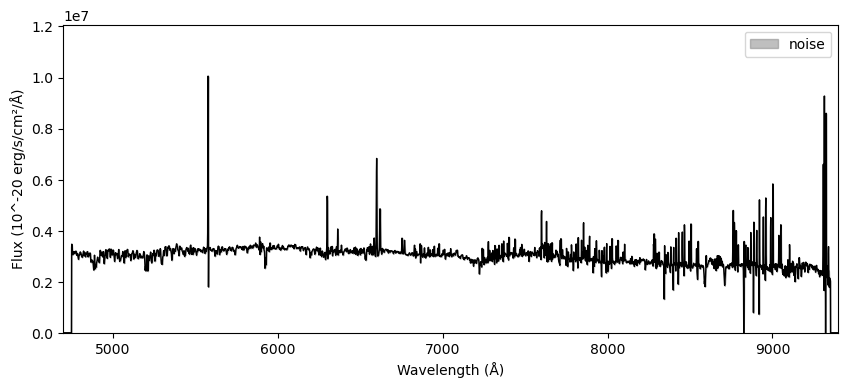

In [5]:
# Cell 5: Sum over **all** spatial pixels, ignoring NaNs
galaxy_spec  = np.nansum(data, axis=(1, 2))           # shape = (nz,)
galaxy_noise = np.sqrt(np.nansum(stat, axis=(1, 2)))  # shape = (nz,)

print("Galaxy spec / noise shapes:", galaxy_spec.shape, galaxy_noise.shape)

# Plot the spectrum
plt.figure(figsize=(10, 4))
plt.plot(wave, galaxy_spec, color="black", lw=1)
plt.fill_between(wave, galaxy_spec - galaxy_noise, galaxy_spec + galaxy_noise,
                 color="gray", alpha=0.5, label="noise")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (10^-20 erg/s/cm²/Å)")
# plt.title("Spectrum of IC 3392")
plt.xlim(wave[0], wave[-1])
plt.ylim(0, 1.2 * np.nanmax(galaxy_spec))
plt.legend()
plt.show()

Measured Hα at 6600.0 Å ⇒ z = 0.00567 or v = 1699.317 km/s


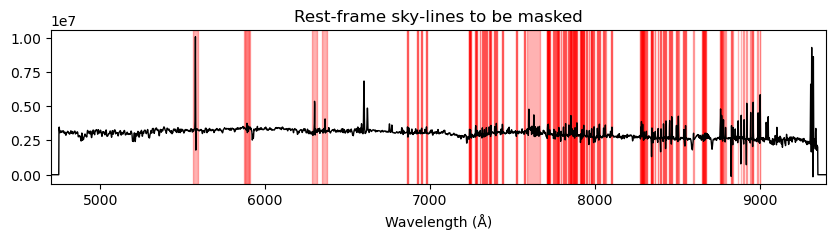

In [6]:
# Cell 5a: Mask only the redshifted sky‐lines in place

# ─── 1) Estimate redshift from Hα ────────────────────────────────────────────
# pick out the strongest feature between 6500–6700Å
idx_ha = np.argmax(galaxy_spec[(wave > 6500) & (wave < 6700)])
full_idx = np.where((wave > 6500) & (wave < 6700))[0][idx_ha]
wave_obs_ha = wave[full_idx]
z = wave_obs_ha / 6562.8 - 1.0
c_kms = c.c.to('km/s').value  # speed of light in km/s
v = z * c_kms
print(f"Measured Hα at {wave_obs_ha:.1f} Å ⇒ z = {z:.5f} or v = {v:.3f} km/s")

# ─── 2) Load the mask file ───────────────────────────────────────────────────
mask_dtype = [('lam', 'f8'), ('width', 'f8'), ('comment', 'U32')]
mask_table = np.genfromtxt(
    "specMask_KIN.txt",
    dtype=mask_dtype,
    comments="#",
    usecols=(0, 1, 2),
    encoding=None
)

# select only sky lines
is_sky     = np.array(["sky" in s.lower() for s in mask_table['comment']])
rest_lams  = mask_table['lam'][is_sky]
rest_width = mask_table['width'][is_sky]

# ─── 3) Build the observed‐frame mask ────────────────────────────────────────
mask = np.zeros_like(wave, dtype=bool)
for lam0, w in zip(rest_lams, rest_width):
    lam_obs = lam0 * (1 + 0)
    half    = (w / 2) * (1 + 0)
    mask |= (wave >= lam_obs - half) & (wave <= lam_obs + half)

# ─── 4) (Optional) Show what we’re masking ─────────────────────────────────
plt.figure(figsize=(10,2))
plt.plot(wave, galaxy_spec, 'k-', lw=1)
for lam0, w in zip(rest_lams, rest_width):
    lam_obs = lam0 * (1 + 0)
    half    = (w / 2) * (1 + 0)
    plt.axvspan(lam_obs - half, lam_obs + half, color='red', alpha=0.3)
plt.xlim(wave.min(), wave.max())
plt.title("Rest-frame sky‐lines to be masked")
plt.xlabel("Wavelength (Å)")
plt.show()

# ─── 5) Fill masked regions with the local continuum (in‐place) ───────────────
good = ~mask
galaxy_spec[mask]  = np.interp(wave[mask],  wave[good], galaxy_spec[good])
galaxy_noise[mask] = np.interp(wave[mask],  wave[good], galaxy_noise[good])

Measured Hα at 6600.0 Å ⇒ z = 0.00567 or v = 1699.317 km/s


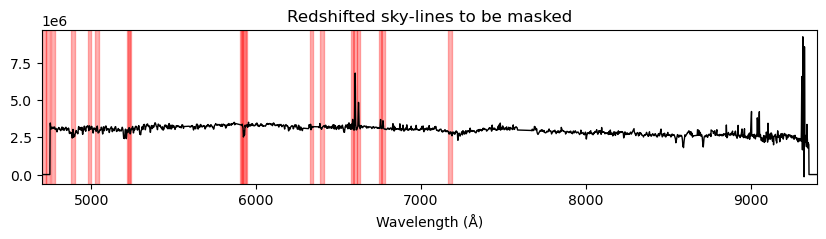

In [7]:
# Cell 5b: Mask only the redshifted galaxy‐lines in place

# ─── 1) Estimate redshift from Hα ────────────────────────────────────────────
# pick out the strongest feature between 6500–6700Å
idx_ha = np.argmax(galaxy_spec[(wave > 6500) & (wave < 6700)])
full_idx = np.where((wave > 6500) & (wave < 6700))[0][idx_ha]
wave_obs_ha = wave[full_idx]
z = wave_obs_ha / 6562.8 - 1.0
c_kms = c.c.to('km/s').value  # speed of light in km/s
v = z * c_kms
print(f"Measured Hα at {wave_obs_ha:.1f} Å ⇒ z = {z:.5f} or v = {v:.3f} km/s")

# ─── 2) Load the mask file ───────────────────────────────────────────────────
mask_dtype = [('lam', 'f8'), ('width', 'f8'), ('comment', 'U32')]
mask_table = np.genfromtxt(
    "specMask_KIN.txt",
    dtype=mask_dtype,
    comments="#",
    usecols=(0, 1, 2),
    encoding=None
)

# select only sky lines
is_sky     = np.array(["sky" in s.lower() for s in mask_table['comment']])
rest_lams  = mask_table['lam'][~is_sky]
rest_width = mask_table['width'][~is_sky]

# ─── 3) Build the observed‐frame mask ────────────────────────────────────────
mask = np.zeros_like(wave, dtype=bool)
for lam0, w in zip(rest_lams, rest_width):
    lam_obs = lam0 * (1 + z)
    half    = (w / 2) * (1 + z)
    mask |= (wave >= lam_obs - half) & (wave <= lam_obs + half)

# ─── 4) (Optional) Show what we’re masking ─────────────────────────────────
plt.figure(figsize=(10,2))
plt.plot(wave, galaxy_spec, 'k-', lw=1)
for lam0, w in zip(rest_lams, rest_width):
    lam_obs = lam0 * (1 + z)
    half    = (w / 2) * (1 + z)
    plt.axvspan(lam_obs - half, lam_obs + half, color='red', alpha=0.3)
plt.xlim(wave.min(), wave.max())
plt.title("Redshifted sky‐lines to be masked")
plt.xlabel("Wavelength (Å)")
plt.show()

# ─── 5) Fill masked regions with the local continuum (in‐place) ───────────────
good = ~mask
galaxy_spec[mask]  = np.interp(wave[mask],  wave[good], galaxy_spec[good])
galaxy_noise[mask] = np.interp(wave[mask],  wave[good], galaxy_noise[good])


Cut galaxy spec / noise shapes: (1800,) (1800,)


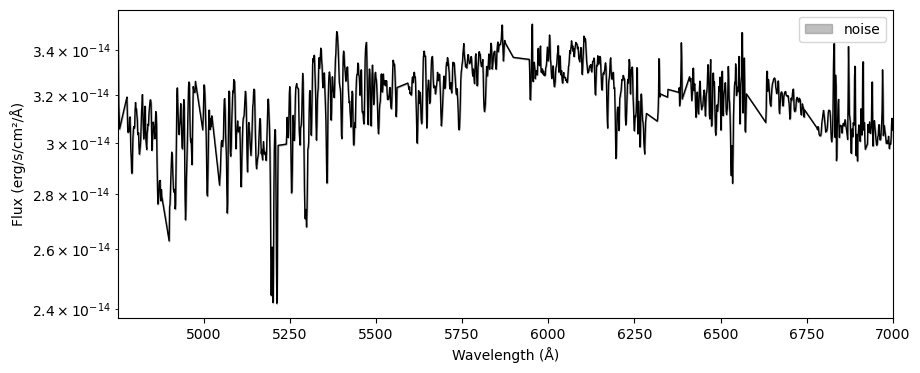

Normalization factor: 1
Normalized galaxy spec / noise shapes: (1800,) (1800,)


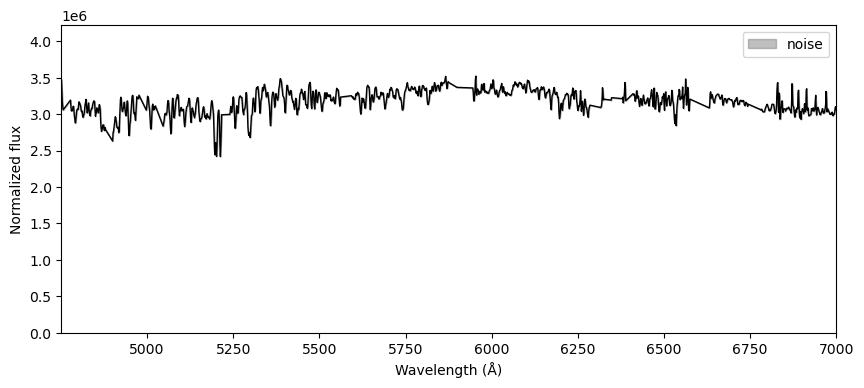

In [8]:
# Cut off the spectrum to a smaller range
wave_cut = (wave < 7000) & (wave > 4750)
# wave_cut = (wave < 7000)
galaxy_spec  = galaxy_spec[wave_cut]
galaxy_noise = galaxy_noise[wave_cut]
wave = wave[wave_cut]
print("Cut galaxy spec / noise shapes:", galaxy_spec.shape, galaxy_noise.shape)

# # remove the outliers that mediam plus minus 3 sigma of the median
# galaxy_spec = np.clip(galaxy_spec, np.nanmedian(galaxy_spec) - 3 * robust_sigma(galaxy_spec),
#                       np.nanmedian(galaxy_spec) + 3 * robust_sigma(galaxy_spec))
# galaxy_noise = np.clip(galaxy_noise, np.nanmedian(galaxy_noise) - 3 * robust_sigma(galaxy_noise),
#                       np.nanmedian(galaxy_noise) + 3 * robust_sigma(galaxy_noise))


# Plot the spectrum
plt.figure(figsize=(10, 4))
plt.plot(wave, galaxy_spec*1e-20, color="black", lw=1)
plt.fill_between(wave, (galaxy_spec - galaxy_noise)*1e-20, (galaxy_spec + galaxy_noise)*1e-20,
                 color="gray", alpha=0.5, label="noise")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (erg/s/cm²/Å)")
# plt.title("Spectrum of IC 3392")
plt.xlim(wave[0], wave[-1])
plt.legend()
plt.yscale("log")
plt.show()

# Normalize the spectrum to near unity
nomalize_factor = np.nanmedian(galaxy_spec)
nomalize_factor = 1
print("Normalization factor:", nomalize_factor)
galaxy_spec /= nomalize_factor
galaxy_noise /= nomalize_factor
print("Normalized galaxy spec / noise shapes:", galaxy_spec.shape, galaxy_noise.shape)
# Plot the spectrum
plt.figure(figsize=(10, 4))
plt.plot(wave, galaxy_spec, color="black", lw=1)
plt.fill_between(wave, galaxy_spec - galaxy_noise, galaxy_spec + galaxy_noise,
                 color="gray", alpha=0.5, label="noise")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Normalized flux")
# plt.title("Spectrum of IC 3392")
plt.xlim(wave[0], wave[-1])
plt.ylim(0, 1.2 * np.nanmax(galaxy_spec))
plt.legend()
plt.show()

In [9]:
# Cell 6: Log‐rebin the galaxy spectrum
from ppxf.ppxf_util import log_rebin

# bounds in Angstroms from your wave array:
wave_start, wave_end = wave[0], wave[-1]

sigma_instr_gal = c_kms*np.log(np.max(wave)/np.min(wave))/(len(wave)-1)  # km/s
v_scale = np.min(c_kms*np.diff(np.log(wave))) # Preserve smallest velocity step

# log_rebin returns: rebinned flux, log‐λ vector, and velscale (km/s per pixel)
gal_flux_log, loglam, velscale = log_rebin([wave_start, wave_end], galaxy_spec, 
                                           velscale=v_scale 
                                           )

# # Convert noise too (same spacing)
# gal_noise_log, _, _ = log_rebin([wave_start, wave_end],
#                                 galaxy_noise,
#                                 velscale=velscale)

print("velscale:", sigma_instr_gal)
print(f"Velocity scale = {velscale:.2f} km/s per pixel")
print(f"Log‐λ range: {loglam[0]:.2f} – {loglam[-1]:.2f}")



velscale: 64.57493012534276
Velocity scale = 53.54 km/s per pixel
Log‐λ range: 8.47 – 8.85


In [10]:
np.min(c_kms*np.diff(np.log(wave)))

np.float64(53.5391479231052)

In [11]:
np.min(np.diff(np.log(wave))), np.min(np.diff(np.log(wave)))*3e5, np.max(np.diff(np.log(wave))), np.max(np.diff(np.log(wave)))*3e5,

(np.float64(0.00017858737434650607),
 np.float64(53.57621230395182),
 np.float64(0.0002630540591255226),
 np.float64(78.91621773765678))

In [12]:
np.diff(wave)[0]/np.max(wave), np.diff(wave)[0]/np.max(wave)*3e5

(np.float64(0.0001785714285714286), np.float64(53.57142857142858))

In [13]:
np.diff(loglam)[0], np.diff(loglam)[0]*3e5

(np.float64(0.00017858737434650607), np.float64(53.57621230395182))

In [14]:
# # Cell 7: Fetch & load the SPS templates shipped with pPXF (corrected keys)
# from pathlib import Path
# from urllib import request
# import numpy as np
# import ppxf.sps_util as lib

# # 1) Choose your SPS set
# # sps_name = "fsps"    # or "galaxev", "emiles", "xsl"
# # sps_name = "galaxev"  # or "fsps". "emiles", "xsl"
# sps_name = "emiles"  # or "fsps". "galaxev", "xsl"

# # 2) Locate the NPZ in the pPXF install
# ppxf_dir = Path(lib.__file__).parent
# basename = f"spectra_{sps_name}_9.0.npz"
# filename = ppxf_dir / "sps_models" / basename

# # 3) Download if missing
# if not filename.is_file():
#     url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
#     print("Downloading SPS templates…")
#     request.urlretrieve(url, filename)

# # 4) Load with the correct keys
# sps = np.load(filename)         # now sps is a valid NpzFile object
# # FWHM_gal = None   # set this to None to skip templates broadening
# # sps = lib.sps_lib(filename, v_scale, FWHM_gal, norm_range=[5070, 5950])
# wave_sps   = sps["lam"]         # wavelength grid [Å]
# flux_sps   = sps["templates"]   # shape (ntemplates, nwave)
# masses     = sps["masses"]      # stellar masses for each SSP
# ages       = sps["ages"]        # SSP ages [Gyr]
# metals     = sps["metals"]      # SSP metallicities [Z/H]
# fwhm_sps   = sps["fwhm"]        # FWHM resolution of the templates

# print(f"Loaded {flux_sps.shape[0]} templates from {wave_sps[0]:.0f}–{wave_sps[-1]:.0f} Å")


In [15]:
# # Cell 8: Reshape, log-rebin & resample SPS templates to galaxy log-λ grid

# import numpy as np
# from ppxf.ppxf_util import log_rebin
# from scipy.ndimage import gaussian_filter1d

# # 1) Flatten SPS cube (n_wave, n_age, n_met) → (n_templates, n_wave)

# # # Convert FWHM_gal (Å) into pixels on the SPS’s linear grid:
# # FWHM_gal = 2.9
# # Δλ_sps = np.mean(np.diff(wave_sps))               # Å per pixel in the SPS file
# # sigma_pix = (FWHM_gal / 2.355) / Δλ_sps            # sigma in pixels

# # # Convolve *each* template spectrum along its wavelength axis:
# # flux_sps_broadened = gaussian_filter1d(flux_sps, sigma_pix, axis=1)

# # # Now continue exactly as before, but use flux_sps_broadened
# # #    in place of flux_sps when you build `flux_2d`:
# # n_wave, n_age, n_met = flux_sps_broadened.shape
# # flux_2d = flux_sps_broadened.transpose(1,2,0).reshape(n_age*n_met, n_wave)

# # nt = flux_2d.shape[0]
# # print("Templates before rebin:", flux_2d.shape, "(n_templates, n_wave)")

# n_wave, n_age, n_met = flux_sps.shape
# flux_2d = flux_sps.transpose(1,2,0).reshape(n_age*n_met, n_wave)
# nt = flux_2d.shape[0]
# print("Templates before rebin:", flux_2d.shape, "(n_templates, n_wave)")

# # 2) (gal_flux_log, loglam, velscale) already computed in Cell 6

# # 3) Allocate array for the final, matched templates
# tpls_log = np.zeros((nt, len(loglam)))

# # 4) Define fitting bounds in Angstrom
# bounds = [wave_sps[0], wave_sps[-1]]

# # 5) Loop: log-rebin each template *and* then interp onto galaxy loglam
# for i in range(nt):
#     spec_i, loglam_i, vs_i = log_rebin(bounds, flux_2d[i], velscale=v_scale)
#     tpls_log[i] = np.interp(loglam, loglam_i, spec_i,
#                             left=spec_i[0], right=spec_i[-1])

# print("Templates rebinned & resampled to galaxy grid:", tpls_log.shape)
# assert tpls_log.shape[1] == len(loglam)

# # 6) Rebin the noise *with* velscale=None to force the same Δlnλ steps
# wave_start, wave_end = wave[0], wave[-1]
# noise_log, _, _ = log_rebin(
#     [wave_start, wave_end],
#     galaxy_noise,
#     velscale=v_scale
# )

# # Ensure positive, finite noise
# bad = (~np.isfinite(noise_log)) | (noise_log <= 0)
# if bad.any():
#     noise_log[bad] = np.nanmedian(noise_log)

# gal_noise_log = noise_log
# print("Rebinned noise:", gal_noise_log.shape,
#       "min, max =", gal_noise_log.min(), gal_noise_log.max())


In [16]:
# ── Cell 7b: Load & LSF-match SPS grid in one shot ─────────────────────────────
from pathlib import Path
from urllib import request
import numpy as np
import ppxf.sps_util as lib

# 1) pick your library
sps_name = "emiles"    # or "fsps", "galaxev", "xsl"
ppxf_dir = Path(lib.__file__).parent
npz      = ppxf_dir / "sps_models" / f"spectra_{sps_name}_9.0.npz"
if not npz.exists():
    url = f"https://raw.githubusercontent.com/micappe/ppxf_data/main/{npz.name}"
    print("Downloading SPS templates…")
    request.urlretrieve(url, npz)

# 2) measure or look up your MUSE LSF: e.g. from Emsellem+2022: FWHM(λ) = a λ² + b λ + c
lam_grid = wave  # your linear Å grid from Cell 4
fwhm_gal = (5.866e-8 * lam_grid**2
            - 9.187e-4 * lam_grid
            + 6.040)    # → array of FWHM in Å

# 3) now call sps_lib: it will convolve and log-rebin for you
#    - velscale is the km/s per ln-pixel from your Cell 6
#    - norm_range is optional (for regularization later)
sps = lib.sps_lib(npz, velscale, fwhm_gal, norm_range=[5070, 5950])

# 4) unpack
tpls_log    = sps.templates       # shape = (n_pixels, n_templates)
loglam_temp = sps.lam_temp        # shape = (n_pixels,)
ml_temp     = getattr(sps, "ml", None)
print("  → templates:", tpls_log.shape)
print("  → loglam  :", loglam_temp.min(), "–", loglam_temp.max())

# Now your galaxy arrays (gal_flux_log, gal_noise_log, loglam) must be
# **trimmed** to the exact same loglam window:

mask = (loglam >= loglam_temp[0]) & (loglam <= loglam_temp[-1])
loglam      = loglam[mask]
gal_flux    = gal_flux_log[mask]
gal_noise   = gal_noise_log[mask]
tpls_log    = tpls_log[mask, :]    # still (n_pix, n_temp)
print("After alignment, galaxy & templates both have", len(loglam), "pixels")

# You can now feed these directly into ppxf:
#   ppxf(tpls_log, gal_flux, gal_noise, velscale, start, ...)


ValueError: operands could not be broadcast together with shapes (1800,) (16675,) 

Keeping 2171 / 2171 pixels
Outliers: 2048
Outliers: 3
Outliers: 2045
Outliers: 2
Outliers: 2048
Outliers: 1
Outliers: 2050
Outliers: 1
Outliers: 2039
Outliers: 3
Outliers: 1
Outliers: 1
 Best Fit:       Vel     sigma
 comp.  0:      1836       900
chi2/DOF: 1.927; DOF: 125; degree = 12; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 113; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
V = 1835.876 km/s, σ = 899.580 km/s


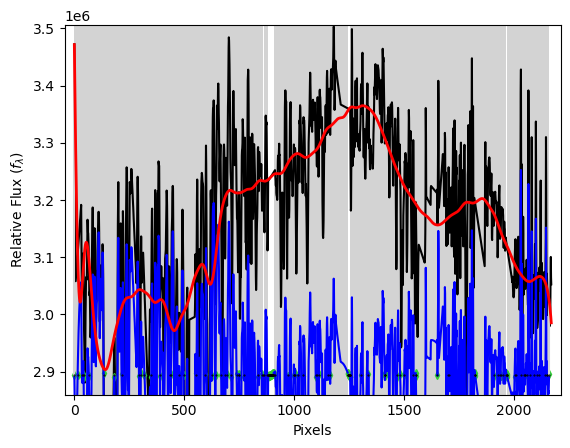

In [ ]:
# Cell 9: Mask out any non-finite pixels and do the pPXF fit
good = np.isfinite(gal_flux_log)

print(f"Keeping {good.sum()} / {len(gal_flux_log)} pixels")

# Trim everything to only the good pixels
gal_flux_good  = gal_flux_log[good]
gal_noise_good = gal_noise_log[good]
tpls_log_good  = tpls_log[:, good]
loglam_good    = loglam[good]

# Now run pPXF on the masked vectors:
from ppxf.ppxf import ppxf

start = [v, v_scale] # V, sigma guesses [km/s]
pp = ppxf(
    tpls_log_good.T,       # (n_velpixels_good × n_templates)
    gal_flux_good,         # (n_velpixels_good,)
    gal_noise_good,        # (n_velpixels_good,)
    velscale,              # km/s per pixel
    start,                 
    moments=2,
    mdegree=-1,
    degree=12,
    clean=True,
    plot=True,
    goodpixels=np.arange(gal_flux_good.size)  # all these indices are 'good'
)


print(f"V = {pp.sol[0]:.3f} km/s, σ = {pp.sol[1]:.3f} km/s")


In [ ]:
# Cell 10: Compute true M_sun/L_sun and log10(M/L)

# 1) Get the best-fit weights
weights = pp.weights            # shape = (n_templates,)

# Flatten the mass array exactly as you did for the flux → M_i [M_sun]
#    sps["masses"].shape == (n_age, n_met)
#    You transposed and reshaped the flux in .transpose(1,2,0).reshape(...)
#    Here masses lives on (n_age, n_met), so:
masses_2d = sps["masses"].T.reshape(-1)*nomalize_factor      # (n_age*n_met,)

# Integrate each template over wavelength → L_i [L_sun]
#    wave_sps is in Angstrom, flux_2d in L_sun/Å, so trapz gives L_sun
L_i = np.trapezoid(flux_2d, wave_sps, axis=1)*nomalize_factor    # shape (n_templates,)

# Composite mass & light
M_tot = np.dot(weights, masses_2d)           # in M_sun
L_tot = np.dot(weights, L_i)                 # in L_sun

# Compute M/L and log₁₀(M/L)
M_L    = M_tot / L_tot
logM_L = np.log10(M_L)

print(f"Composite mass   = {M_tot:.3f} M_sun = log₁₀(M) = {np.log10(M_tot):.3f}")
print(f"Composite light  = {L_tot:.3f} L_sun = log₁₀(L) = {np.log10(L_tot):.3f}")
print(f"Composite M/L   = {M_L:.3f} M_sun/L_sun = log₁₀(M/L) = {logM_L:.3f}")


Composite mass   = 410279544.130 M_sun = log₁₀(M) = 8.613
Composite light  = 4317828289.722 L_sun = log₁₀(L) = 9.635
Composite M/L   = 0.095 M_sun/L_sun = log₁₀(M/L) = -1.022
